# Import Libraries
This cell imports all the necessary libraries for data handling, model building, training, and visualization.

- `numpy`: For numerical operations
- `tensorflow`: For building and training deep learning models.
- `os`: For interacting with the operating system to reading file paths and managing directories.
- `re`: For regular expression operations to pattern matching in strings.
- `matplotlib.pyplot`: For creating visualizations to plots and graphs.
- `random`: For generating random numbers and making random selections for data shuffling and augmentation.
- `PIL.Image`: From the Python Imaging Library (PIL), used for opening, manipulating, and saving image files.
- `sklearn.model_selection`: For splitting the dataset into training and testing sets.
- `sklearn.metrics`: For evaluating the model's performance
- `tensorflow.keras.backend`: For accessing TensorFlow Keras backend functions
- `tensorflow.keras.layers`: For creating different types of neural network layers
- `tensorflow.keras.models`: For defining and training neural network models.
- `tensorflow.keras.optimizers`: For specifying optimization algorithms to train the model.

In [1]:
# Import necessary libraries
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Input, Lambda, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
import random

### Reading PGM Images and Labels 
- Open File: The function opens the specified file in binary read mode.
- Read Buffer: The entire content of the file is read into a buffer.
- Extract Header Information: A regular expression is used to parse the header of the PGM file.

In [2]:
# Function to read PGM images
def read_image(filename, byteorder='>'):
    with open(filename, 'rb') as f:
        buffer = f.read()

    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()

    return np.frombuffer(buffer, dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                         count=int(width)*int(height), offset=len(header)).reshape((int(height), int(width)))

### Prepare Data for Training and Testing
* preparing the data for training and testing a neural network model by creating pairs of genuine (same person) and impostor (different person) images from dataset.
* The resulting dataset consists of pairs of images, each pair being either genuine or impostor.
* Each pair is labeled appropriately (1 for genuine, 0 for impostor).
* Initializes arrays for storing genuine pairs (x_genuine_pair) and their labels (y_genuine).
* Iterates through each class (40 classes in total). For each class, randomly selects pairs of images from the same class.
* The images are normalized and ready for use in training and testing .

In [3]:
# Function to get data for training and testing
def get_data(base_path, size, total_sample_size):
    image = read_image(os.path.join(base_path, 's1/1.pgm'), 'rw+')
    image = image[::size, ::size]
    dim1, dim2 = image.shape

    x_genuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_genuine = np.ones([total_sample_size, 1])
    count = 0
    for i in range(40):
        for j in range(total_sample_size // 40):
            ind1, ind2 = np.random.choice(10, 2, replace=False)
            img1 = read_image(os.path.join(base_path, f's{i+1}/{ind1+1}.pgm'), 'rw+')[::size, ::size]
            img2 = read_image(os.path.join(base_path, f's{i+1}/{ind2+1}.pgm'), 'rw+')[::size, ::size]
            x_genuine_pair[count, 0, 0, :, :] = img1
            x_genuine_pair[count, 1, 0, :, :] = img2
            count += 1

    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    count = 0
    for i in range(total_sample_size // 10):
        for j in range(10):
            ind1, ind2 = np.random.choice(40, 2, replace=False)
            img1 = read_image(os.path.join(base_path, f's{ind1+1}/{j+1}.pgm'), 'rw+')[::size, ::size]
            img2 = read_image(os.path.join(base_path, f's{ind2+1}/{j+1}.pgm'), 'rw+')[::size, ::size]
            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            count += 1

    X = np.concatenate([x_genuine_pair, x_imposite_pair], axis=0) / 255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)
    return X, Y


## Improved Model
The Siamese network consists of multiple layers to enhance its ability to learn complex patterns from the input data. The architecture includes convolutional layers, activation functions, pooling layers, dropout layers, and fully connected (dense) layers.
1. **Input Layer**: The shape of the input image, specified by the input_shape parameter.
2. **Convolutional Layer 1**. 
    - Applies 6 convolutional filters of size 3x3 to the input image.
    - MaxPooling Layer: Reduces the spatial dimensions of the feature maps by taking the maximum value in each 2x2 window.
    - Dropout Layer: Randomly sets 25% of the input units to 0 during training to prevent overfitting.
3. **Convolutional Layer 2**. 
    - Applies 12 convolutional filters of size 3x3 to the feature maps from the previous layer.
    - MaxPooling Layer. Further reduces the spatial dimensions of the feature maps by taking the maximum value in each 2x2 window.
    - Dropout Layer: Randomly sets 25% of the input units to 0 during training to prevent overfitting.
4. **Flattening Layer**. 
    - Converts the 2D feature maps into a 1D feature vector to be fed into fully connected layers.
    - Dense Layer: A fully connected layer with 128 units.
    - Dropout Layer: Randomly sets 10% of the input units to 0 during training to prevent overfitting.
    - Dense Layer: A fully connected layer with 50 units.

In [4]:
# Function to build the base network of the Siamese model
def build_base_network(input_shape):
    seq = Sequential()  
    nb_filter = [6, 12]  
    kernel_size = 3  
    
    # Convolutional Layer 1
    seq.add(Conv2D(nb_filter[0], kernel_size, input_shape=input_shape, padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))  
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))  
    
    # Convolutional Layer 2
    seq.add(Conv2D(nb_filter[1], kernel_size, padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))  
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first')) 
    seq.add(Dropout(.25))  
    
    # Flattening Layer
    seq.add(Flatten())  
    seq.add(Dense(128, activation='relu')) 
    seq.add(Dropout(0.1))  
    seq.add(Dense(50, activation='relu')) 
    
    return seq 


### Distance Calculation
- The Euclidean distance calculation is used to measure the similarity between pairs of images by comparing their feature vectors.
-  Returns a tensor containing the distances between corresponding pairs of elements in x and y.
- *Contrastive Loss Function* - is used to train the neural network by minimizing the distance between feature vectors of similar images and maximizing the distance between feature vectors of dissimilar images.

In [5]:
# Function to calculate Euclidean distance
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

# Contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


## Meta-Learning Implementation
The Model-Agnostic Meta-Learning (MAML). MAML is a meta-learning technique designed to train models that can quickly adapt to new tasks with a few gradient updates. **Implementation of MAML* this model is designed to enable the Siamese network to quickly adapt to new tasks with Face Recognition learning. the training method involves both inner method (task-specific adaptation) and an outer method.

1. **Initialization**  
    - The base model used for meta-learning, the Inner and Outer rate used for the inner and outer update step (updating weights within and across tasks).
    - `k_shots`Number of support per class, which determines how many image examples are used for each class in the support set.
    - `n_way`Number of classes in each task. `noptimizer`Uses RMSprop for the outer meta-update step with learning rate 

2. **Inner Update Method**
The inner_update method performs the task-specific adaptation (inner loop). It updates the model's weights based on the support set examples of a given task. The process involves:
    - Calculating the task-specific loss.
    - Computing gradients of the loss with respect to the model parameters.
    - Updating the model parameters using gradient descent.

3. **Training Step Method** (train_step)
The train_step method performs a meta-training iteration (outer loop). It processes a batch of tasks and involves the following steps:
    1. -Initializing the meta-loss and meta-gradients.
    2. -For each task:
       - Performing the inner update to adapt the model to the task.
       - Calculating the query loss after the inner update.
       - Accumulating the gradients of the query loss with respect to the model parameters.
    3. -Averaging the meta-loss and meta-gradients over the task batch.
    4. -Applying the averaged meta-gradients to the model parameters using the outer loop optimizer.

In [6]:
# MAML implementation class
class MAML:
    def __init__(self, model, lr_inner, lr_outer, k_shot, n_way):
        self.model = model
        self.lr_inner = lr_inner
        self.lr_outer = lr_outer
        self.k_shot = k_shot
        self.n_way = n_way
        self.optimizer = RMSprop(self.lr_outer)
    
    def inner_update(self, model, x_support, y_support):
        with tf.GradientTape() as tape:
            y_pred_support = model([x_support[:, 0], x_support[:, 1]], training=True)
            loss_support = contrastive_loss(y_support, y_pred_support)
        grads = tape.gradient(loss_support, model.trainable_variables)
        k_updater = [(w - self.lr_inner * g) for w, g in zip(model.trainable_variables, grads)]
        return k_updater, grads
    
    def train_step(self, task_batch):
        meta_loss = 0
        meta_grads = [tf.zeros_like(var) for var in self.model.trainable_variables]
        for x_support, y_support, x_query, y_query in task_batch:
            updated_weights, support_grads = self.inner_update(self.model, x_support, y_support)
            with tf.GradientTape() as tape:
                for var, upd in zip(self.model.trainable_variables, updated_weights):
                    var.assign(upd)
                y_pred_query = self.model([x_query[:, 0], x_query[:, 1]], training=True)
                loss_query = contrastive_loss(y_query, y_pred_query)
                meta_loss += tf.reduce_mean(loss_query)
            grads = tape.gradient(loss_query, self.model.trainable_variables)
            meta_grads = [mg + g for mg, g in zip(meta_grads, grads)]
        meta_loss /= len(task_batch)
        meta_grads = [mg / len(task_batch) for mg in meta_grads]
        self.optimizer.apply_gradients(zip(meta_grads, self.model.trainable_variables))
        return meta_loss


## Important Considerations 

1. **Data Loading**
    - The dataset used is stored in the orl_faces directory. The `get_data` function is responsible for generating pairs of images (both genuine and impostor pairs) and their corresponding labels. 
    - The data is then split into training and testing sets with a 75-25 ratio.

2. **Model Architecture:**
    - The build_base_network function should define a network appropriate for extracting features from the face images. that processes each image, and a `Lambda` layer computes the Euclidean distance between the feature vectors of the image pairs.

3. **MAML Initialization**
    - MAML is initialized with the Siamese model. This framework facilitates fast adaptation to new tasks with minimal data.
    - Sets the inner and outer learning rates for the MAML framework.
    - k-shot and n-way: Defines the number of examples per class and the number of classes in the classification task.

4. **Training Loop**
    - The main training loop runs for a specified number of `(num_epochs=100` epochs. In each epoch, a batch of tasks is sampled from the training data. Each task consists of support and query sets. The MAML train_step function performs a meta-update on the model.
    - *Task Batch Creation* For each batch of 16 tasks. Randomly selects 10 indices from x_train.
        - Splits them into support and query sets (first 5 for support, next 5 for query).
        - Appends the support and query sets along with their labels to task_batch.

Meta-Loss Calculation:

    Performs a meta-training step using maml.train_step(task_batch).
    Appends the computed meta-loss to meta_losses.

Training Loss Calculation:

    Predicts on the training set using the Siamese model.
    Computes the contrastive loss and appends it to train_losses.

Training Accuracy Calculation:

    Computes the training accuracy and appends it to train_accs.

Validation Loss Calculation:

    Predicts on the validation set using the Siamese model.
    Computes the contrastive loss and appends it to val_losses.

Validation Accuracy Calculation:

    Computes the validation accuracy and appends it to val_accs.

Output Results:

    Prints the results for each epoch, including meta-loss, training loss, validation loss, training accuracy, and validation accuracy.

In [7]:
# Load data
base_path = 'C:/Users/abdul/OneDrive/Desktop/Meta/Face recognition/dataset/orl_faces'  # Path to the dataset  
x, y = get_data(base_path, size=2, total_sample_size=200)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Build Siamese model
input_dim = x_train.shape[2:]
base_network = build_base_network(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])
siamese_model = Model(inputs=[img_a, img_b], outputs=distance)

# Initialize MAML
maml = MAML(siamese_model, lr_inner=0.01, lr_outer=0.001, k_shot=5, n_way=2)

# Meta-Training Loop with validation loss calculation
num_epochs = 100
meta_losses = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    task_batch = []
    for _ in range(16):  # Batch size of 16 tasks
        task_indices = np.random.choice(len(x_train), size=10, replace=False)
        support_indices = task_indices[:5]
        query_indices = task_indices[5:]
        x_support = x_train[support_indices]
        y_support = y_train[support_indices]
        x_query = x_train[query_indices]
        y_query = y_train[query_indices]
        task_batch.append((x_support, y_support, x_query, y_query))
    
    meta_loss = maml.train_step(task_batch)
    meta_losses.append(meta_loss)
    
    # Calculate training loss
    train_pred = siamese_model.predict([x_train[:, 0], x_train[:, 1]])
    train_loss = contrastive_loss(y_train, train_pred).numpy()
    train_losses.append(train_loss)
    
    # Calculate training accuracy
    train_accuracy = np.mean((train_pred < 0.5).astype(int).ravel() == y_train.ravel())
    train_accs.append(train_accuracy)
    
    # Calculate validation loss
    val_pred = siamese_model.predict([x_test[:, 0], x_test[:, 1]])
    val_loss = contrastive_loss(y_test, val_pred).numpy()
    val_losses.append(val_loss)
    
    # Calculate validation accuracy
    val_accuracy = np.mean((val_pred < 0.5).astype(int).ravel() == y_test.ravel())
    val_accs.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Meta Loss: {meta_loss:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')


c:\Users\abdul\anaconda3\envs\test\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Epoch 1/100, Meta Loss: 0.2765, Train Loss: 0.3623, Val Loss: 0.3568, Train Accuracy: 0.4967, Val Accuracy: 0.5100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Epoch 2/100, Meta Loss: 0.3121, Train Loss: 0.3613, Val Loss: 0.3600, Train Accuracy: 0.4967, Val Accuracy: 0.5100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 3/100, Meta Loss: 0.3283, Train Loss: 0.3438, Val Loss: 0.3412, Train Accuracy: 0.4967, Val Accuracy: 0.5100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 4/100, Meta Loss: 0.3031, Train Loss: 0.3740, Val Loss: 0.3721, Train Accuracy: 0.4967, Val Accuracy: 0.5100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 5/100, Meta Loss: 0.2697, Train Loss: 0.3681, Val Loss: 0.3669, Train Accuracy: 0.4967, Val Accuracy: 0.5100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/

## Visualization of Training Progress
This section visualizes the training progress by plotting the over the epochs.
* Meta-Training Loss: Shows how the meta-training loss changes over epochs, indicating the effectiveness of the meta-learning process.
* Training and Validation Accuracy: Illustrates the model's accuracy on both the training and validation sets, helping to identify overfitting or underfitting.
* Training and Validation Loss: Displays the loss values for the training and validation sets, providing insights into the convergence and stability of the training process.

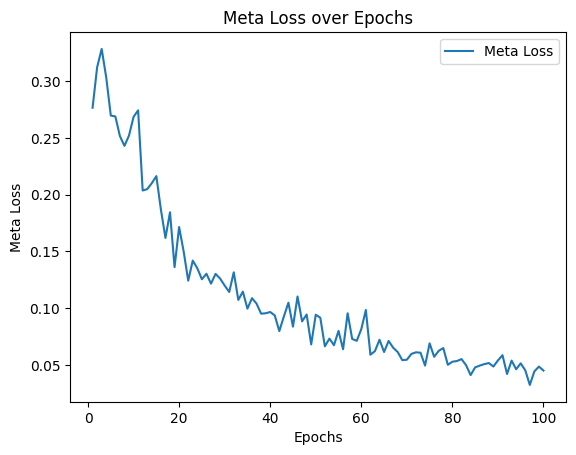

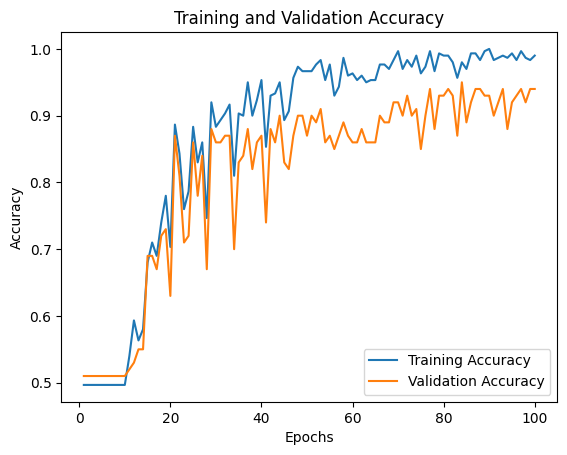

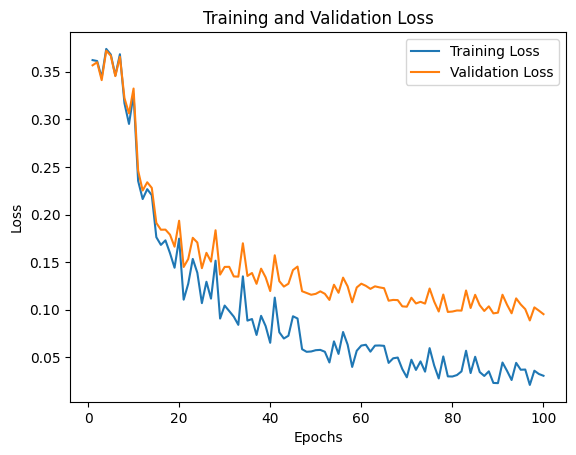

In [10]:
# Plot Meta-Training Loss
plt.figure()
plt.plot(range(1, num_epochs + 1), meta_losses, label='Meta Loss')
plt.xlabel('Epochs')
plt.ylabel('Meta Loss')
plt.title('Meta Loss over Epochs')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluation and Analysis
This Function evaluates the performance of the meta-learned model on validation tasks and provides a detailed analysis of the results, including accuracy, confusion matrix, sample image predictions, and classification metrics.

* Model Accuracy: Calculates and prints the overall accuracy of the model on the test dataset.
* Confusion Matrix: Computes and visualizes the confusion matrix to analyze the distribution of true positives, false positives, true negatives, and false negatives.
* Sample Image Predictions: Displays 30 randomly selected test images along with their predicted and true labels to visually inspect the model's predictions.
* Precision, Recall, F1-Score, and Support: Computes and prints detailed classification metrics for both classes (Imposter and Genuine).
* Summary Statistics: Provides an overall summary of the accuracy, total number of images, and the count of imposter and genuine images in the test dataset.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Model accuracy: 0.94


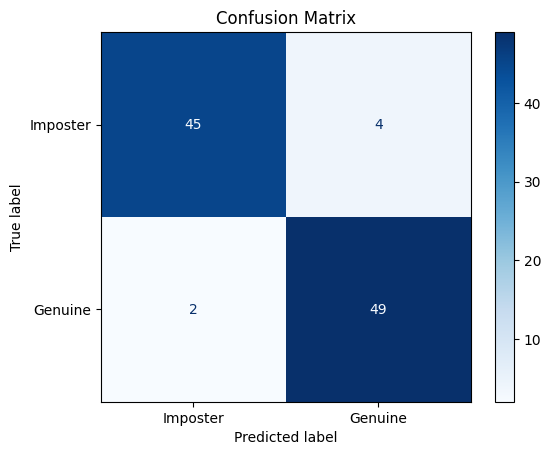

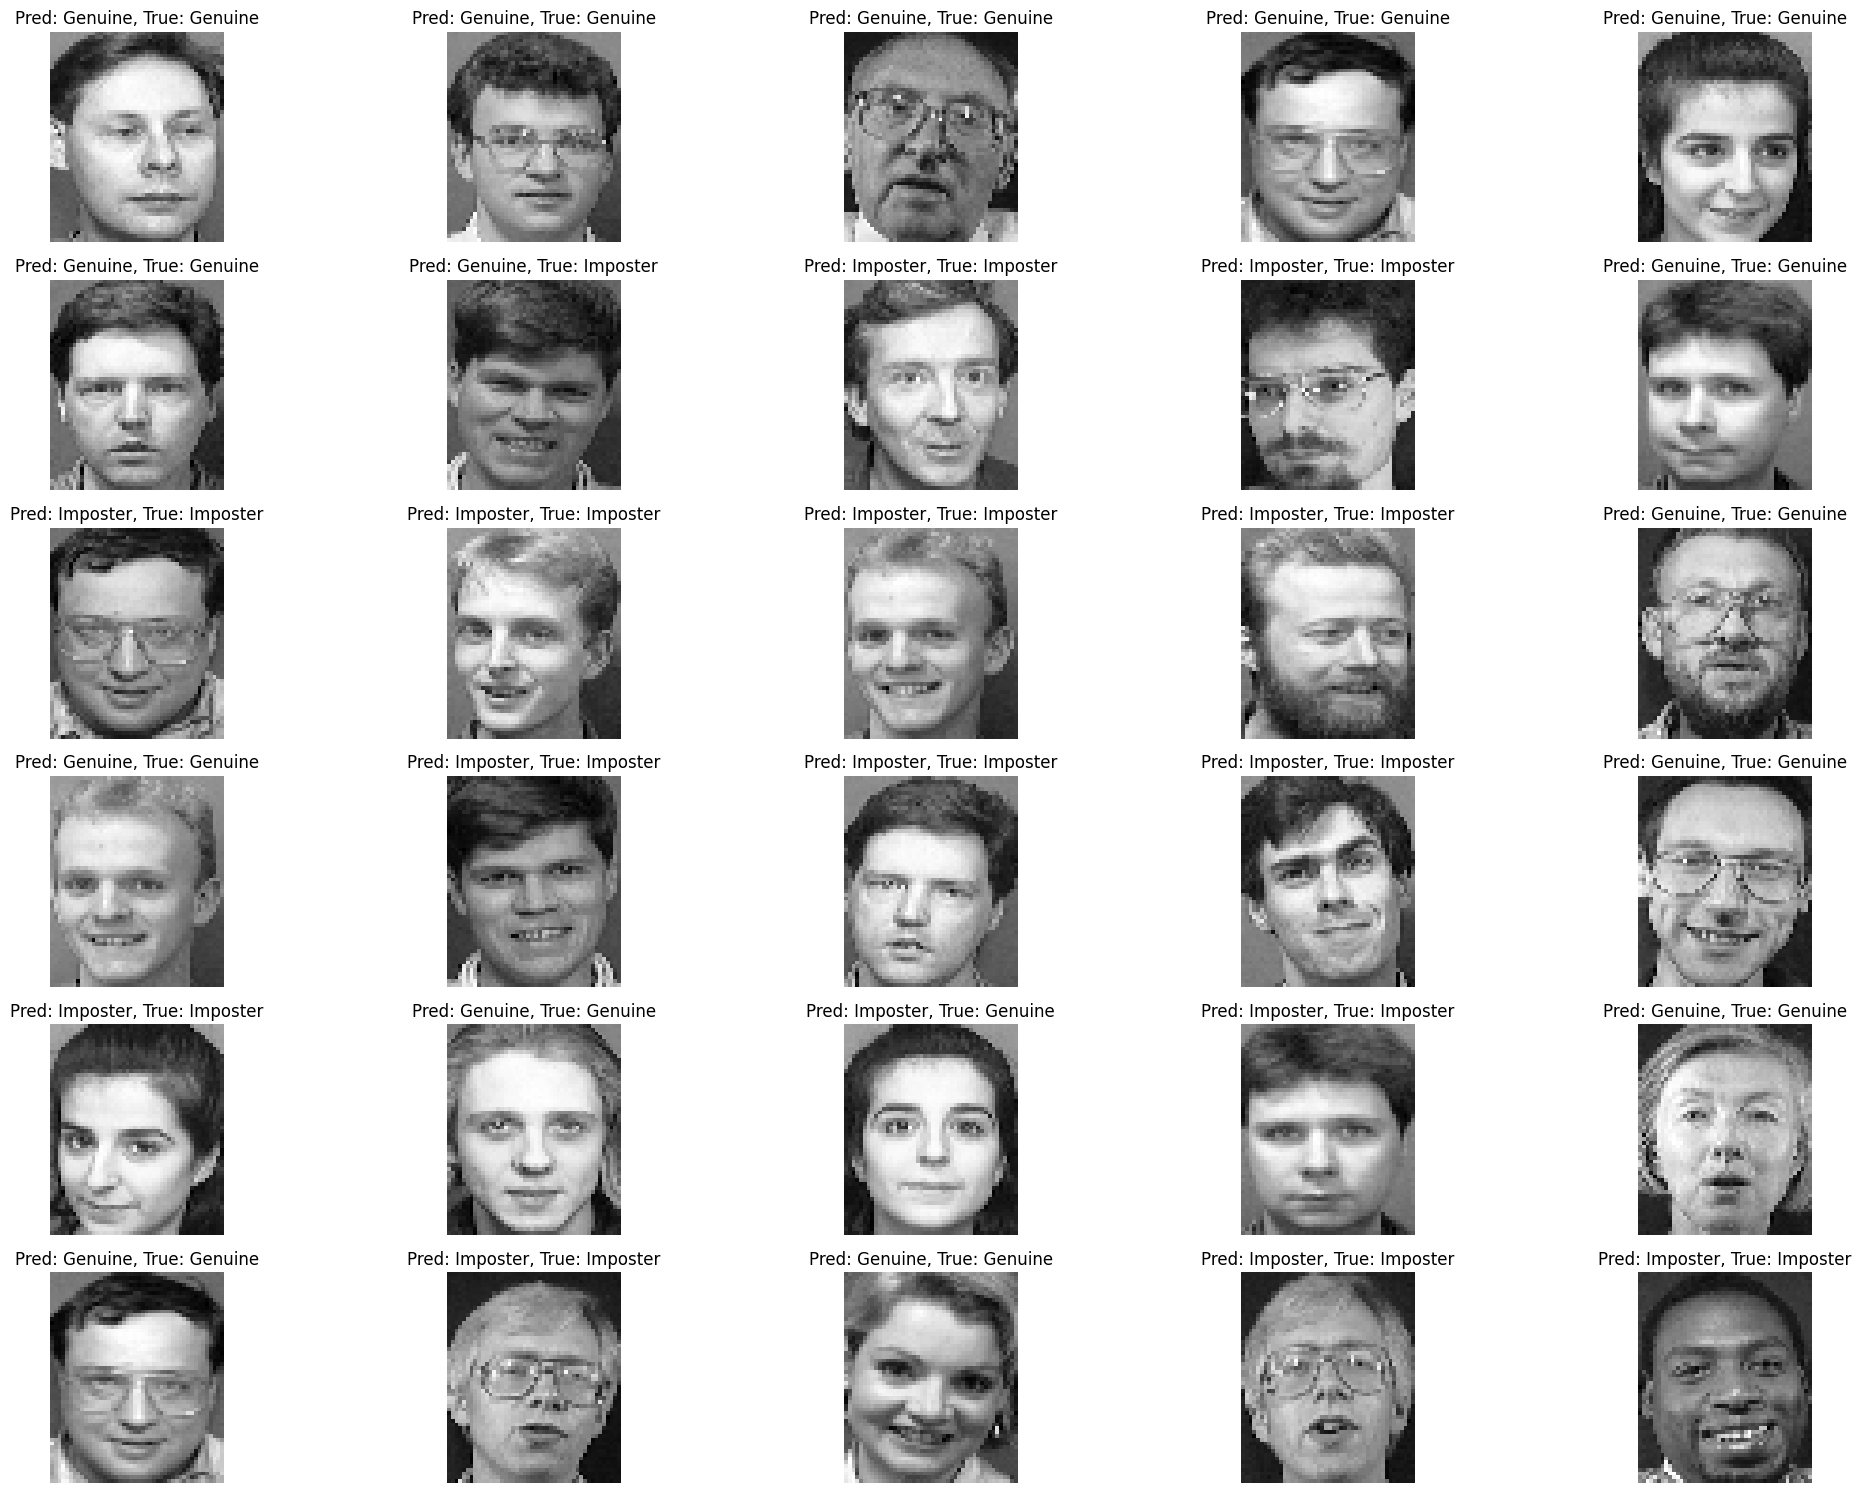

Precision (Imposter): 0.9574468085106383, Recall (Imposter): 0.9183673469387755, F1-score (Imposter): 0.9375, Support (Imposter): 49
Precision (Genuine): 0.9245283018867925, Recall (Genuine): 0.9607843137254902, F1-score (Genuine): 0.9423076923076923, Support (Genuine): 51
Accuracy: 0.94
Total Images: 100
Imposter Images: 49
Genuine Images: 51


In [11]:
# Evaluate the meta-learned model
x_test_1 = x_test[:, 0]
x_test_2 = x_test[:, 1]
pred = siamese_model.predict([x_test_1, x_test_2])
accuracy = np.mean((pred < 0.5).astype(int).ravel() == y_test.ravel())
print(f'Model accuracy: {accuracy}')

# Compute and plot confusion matrix
y_pred = (pred < 0.5).astype(int).ravel()
y_true = y_test.astype(int).ravel()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Imposter', 'Genuine'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Display 30 images after prediction
dim1, dim2 = x_test.shape[-2], x_test.shape[-1]
class_names = {0: 'Imposter', 1: 'Genuine'}
class_count = {0: np.sum(y_test == 0), 1: np.sum(y_test == 1)}

plt.figure(figsize=(20, 20))
indices = random.sample(range(len(x_test)), 30)
for i, idx in enumerate(indices):
    ax = plt.subplot(8, 5, i + 1)
    plt.imshow(x_test[idx, 0].reshape(dim1, dim2), cmap='gray')
    plt.title(f'Pred: {class_names[y_pred[idx]]}, True: {class_names[y_true[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# Compute precision, recall, f1-score, and support
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
print(f'Precision (Imposter): {precision[0]}, Recall (Imposter): {recall[0]}, F1-score (Imposter): {f1[0]}, Support (Imposter): {support[0]}')
print(f'Precision (Genuine): {precision[1]}, Recall (Genuine): {recall[1]}, F1-score (Genuine): {f1[1]}, Support (Genuine): {support[1]}')

# Print accuracy, total amount of images, and amount of imposter and genuine images
total_images = len(y_true)
num_imposter = np.sum(y_true == 0)
num_genuine = np.sum(y_true == 1)
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Total Images: {total_images}')
print(f'Imposter Images: {num_imposter}')
print(f'Genuine Images: {num_genuine}')